### What we will learn

- We will build Kubeflow Pipeline that 
 -- creates Dataset from BigQuery TABLE/VIEW
 -- runs AutoML training on Tabular Dataset
 -- created Vertex AI endpoint
 -- deploys model to Vertex AI endpoint

We will use Vertex AI Kubeflow components

In [1]:
import kfp

In [4]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [30]:
import os


BIGQUERY_PROJECT_ID = os.environ.get('BIGQUERY_PROJECT_ID')
BIGQUERY_DATASET = os.environ.get('BIGQUERY_DATASET')
BIGQUERY_DATASET_REGION = os.environ.get('BIGQUERY_DATASET_REGION')
BIGQUERY_TABLE = os.environ.get('BIGQUERY_TABLE')

VERTEXAI_PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
VERTEXAI_REGION = os.environ.get('VERTEXAI_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BUCKET_URI = os.environ.get('BUCKET_URI')
BUCKET_REGION = os.environ.get('BUCKET_REGION')

PREFIX = os.environ.get('PREFIX')


print("BIGQUERY_PROJECT_ID: ",BIGQUERY_PROJECT_ID)
print("BIGQUERY_DATASET: ",BIGQUERY_DATASET)
print("BIGQUERY_DATASET_REGION: ",BIGQUERY_DATASET_REGION)
print("BIGQUERY_TABLE: ",BIGQUERY_TABLE)

print("VERTEXAI_PROJECT_ID: ",VERTEXAI_PROJECT_ID)
print("VERTEXAI_REGION: ",VERTEXAI_REGION)

print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_NAME)
print("BUCKET_REGION: ",VERTEXAI_REGION)


PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)
LABELS = {}

BIGQUERY_PROJECT_ID:  datafusionsbox
BIGQUERY_DATASET:  dataset4ccc
BIGQUERY_DATASET_REGION:  us
BIGQUERY_TABLE:  df_for_model_ccc_with_weights
VERTEXAI_PROJECT_ID:  datafusionsbox
VERTEXAI_REGION:  us-central1
BUCKET_NAME:  gcp-demo-ccc-vertexai
BUCKET_URI:  gcp-demo-ccc-vertexai
BUCKET_REGION:  us-central1


In [1]:
import google_cloud_pipeline_components
print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))

google_cloud_pipeline_components version: 1.0.33


In [2]:
from google_cloud_pipeline_components.experimental.automl.tabular import \
    utils as automl_tabular_utils

/home/jupyter/.local/lib/python3.7/site-packages/kfp/components/v1_components.py:35: FutureWarning: Container component must specify command to be compatible with KFP v2 compatible mode and emissary executor, which will be the default executor for KFP v2.https://www.kubeflow.org/docs/components/pipelines/installation/choose-executor/
  category=FutureWarning,


In [6]:
from google.cloud import aiplatform
aiplatform.init(project=VERTEXAI_PROJECT_ID, location=VERTEXAI_REGION)

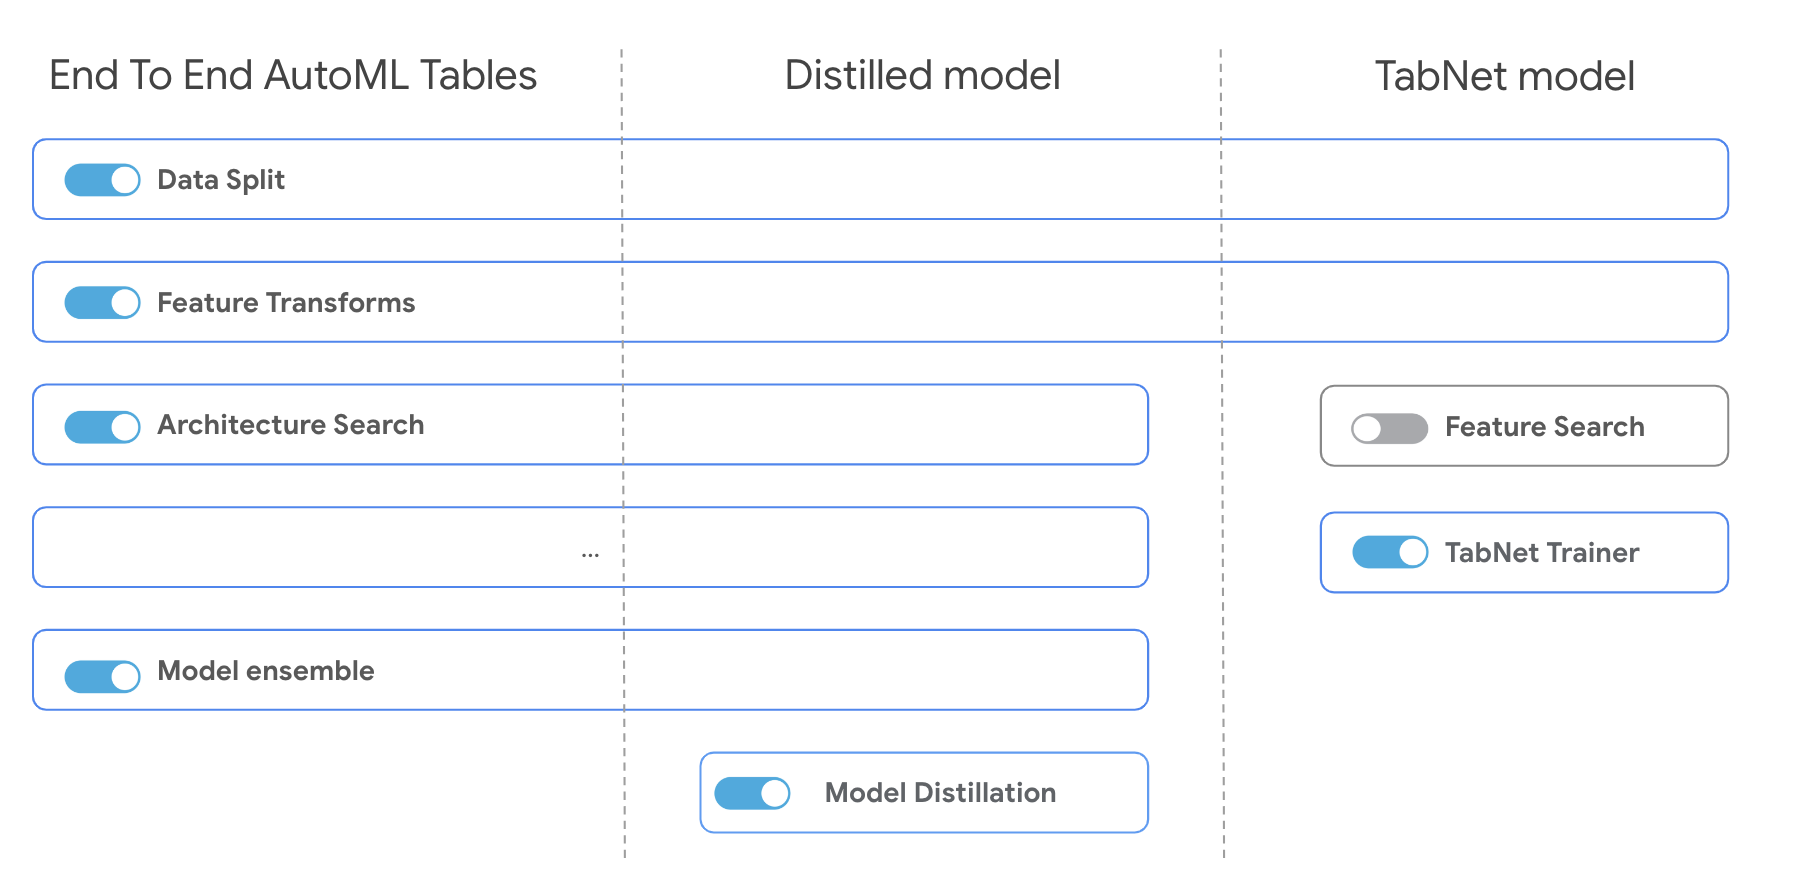

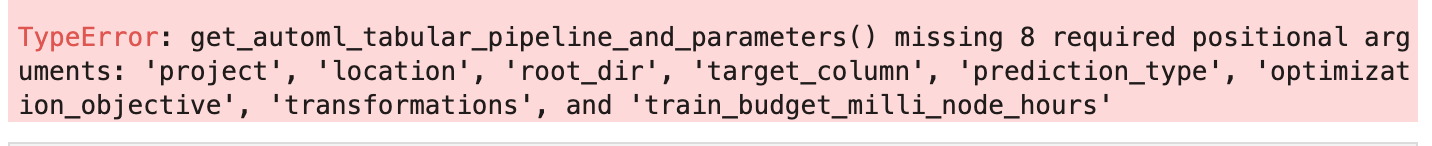

https://cloud.google.com/vertex-ai/docs/tabular-data/tabular-workflows/e2e-automl

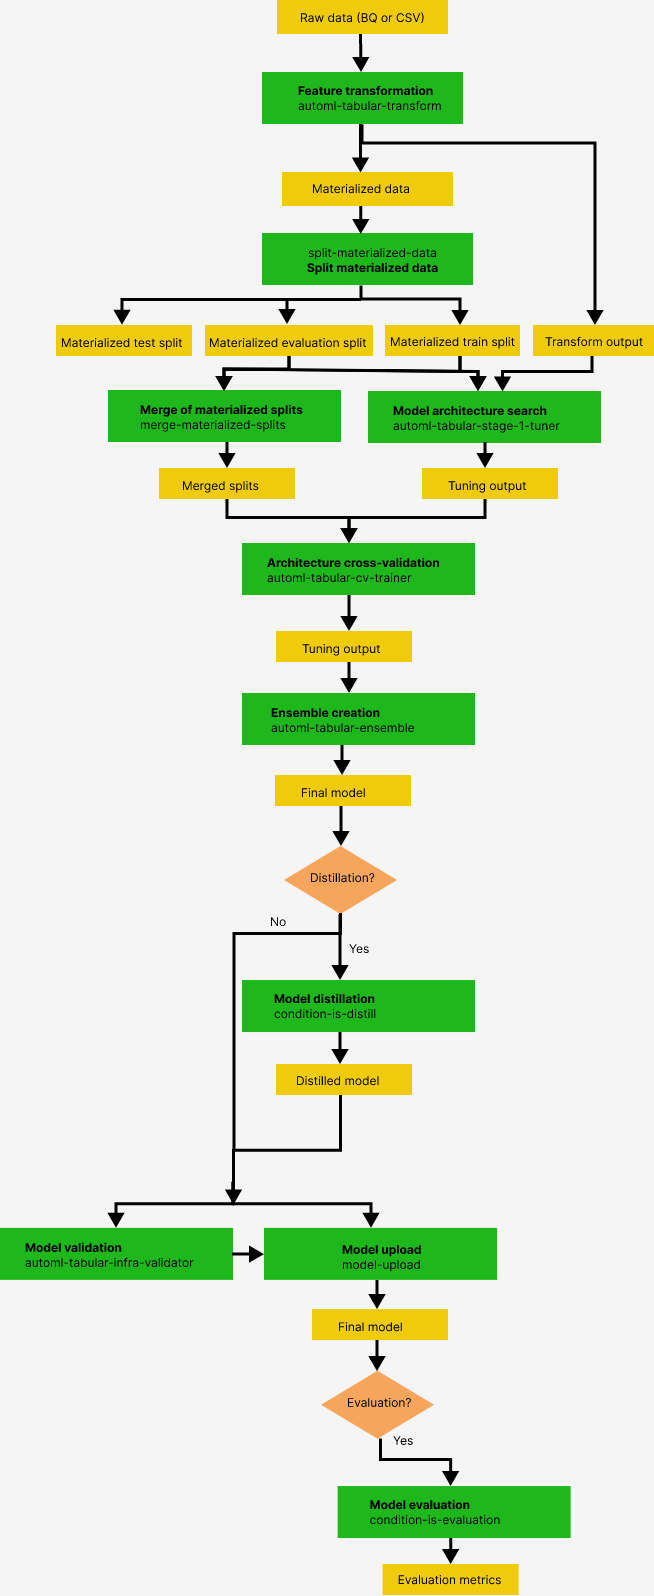

### Feature tranformation: Feature transformation engine

In [57]:
table_id = f"{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"
_excluded_columns = ["synerise_client_id", 
                    "y_if_trans", ##--Error: 'Target column y_if_trans cannot be specified in transformations.'
                    "weight"]    ##Error: 'Weight column weight cannot be specified in transformations.'

In [58]:
from typing import Any, Dict, List
from google.cloud import storage

def generate_auto_transformation(column_names: List[str]) -> List[Dict[str, Any]]:
    transformations = []
    for column_name in column_names:
        transformations.append({"auto": {"column_name": column_name}})
    return transformations

## gs://bucket1/folder1/folder2/file.json.  -> return bucket1  folder1/folder2/file.json
def get_bucket_name_and_path(uri):
    no_prefix_uri = uri[len("gs://") :]
    splits = no_prefix_uri.split("/")
    return splits[0], "/".join(splits[1:])


def write_to_gcs(uri: str, content: str):
    bucket_name, path = get_bucket_name_and_path(uri)
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(path)
    blob.upload_from_string(content)

In [59]:
from google.cloud import bigquery

client = bigquery.Client()
table = client.get_table(table_id)  # Make an API request.

print(
    "Got table '{}.{}.{}'.".format(table.project, table.dataset_id, table.table_id)
)


Got table 'datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights'.


In [60]:
column_names = []
for schema_field in table.schema:
    if schema_field.name not in _excluded_columns:
       column_names.append(schema_field.name)
       print(schema_field.name)
    
##print(column_names)

www_visits_month_freq_1
www_visits_month_freq_2
www_visits_month_freq_3
www_pages_visited_month_1
www_pages_visited_month_2
www_pages_visited_month_3
www_time_onsite_avg_month_1
www_time_onsite_avg_month_2
www_time_onsite_avg_month_3
www_trans_month_freq_1
www_trans_month_freq_2
www_trans_month_freq_3
www_basket_value_monthly_1
www_basket_value_monthly_2
www_basket_value_monthly_3
www_coupon_add_month_1
www_coupon_add_month_2
www_coupon_add_month_3
www_device_freq_mobile
www_device_freq_desktop
www_umbrella_click_month_1
www_umbrella_click_month_2
www_umbrella_click_month_3
www_promo_click_month_1
www_promo_click_month_2
www_promo_click_month_3
www_gallery_click_month_1
www_gallery_click_month_2
www_gallery_click_month_3
www_channel_freq__direct_organic
www_channel_freq__sem
www_channel_freq__facebook
www_channel_freq__portale
www_channel_freq__klub
www_channel_freq__afiliacja
www_channel_freq__retargeting
www_channel_freq__traffic
www_channel_freq__porownywarki
www_esizeme_freq_esizme

In [61]:
import json
transform_config_path = os.path.join(PIPELINE_ROOT, f"transform_config.json")
transformations = generate_auto_transformation(column_names)
write_to_gcs(transform_config_path, json.dumps(transformations))

In [62]:
worker_pool_specs_override = [
    {"machine_spec": {"machine_type": "n1-standard-8"}},  # override for TF chief node
    {},  # override for TF worker node, since it's not used, leave it empty
    {},  # override for TF ps node, since it's not used, leave it empty
    {
        "machine_spec": {
            "machine_type": "n1-standard-4"  # override for TF evaluator node
        }
    },
]

In [63]:
##https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.16/google_cloud_pipeline_components.experimental.automl.tabular.html?highlight=get_automl_tabular_pipeline_and_parameters#google_cloud_pipeline_components.experimental.automl.tabular.utils.get_automl_tabular_pipeline_and_parameters

(template_path,parameter_values) = automl_tabular_utils.get_automl_tabular_pipeline_and_parameters(
project=VERTEXAI_PROJECT_ID,
location=VERTEXAI_REGION,
root_dir=PIPELINE_ROOT,
target_column="y_if_trans",
weight_column="weight",
prediction_type="classification",
optimization_objective="maximize-precision",
train_budget_milli_node_hours=2000,
##Data source
data_source_bigquery_table_path=f"bq://{table_id}",
##Data Split
    training_fraction=0.6,
    validation_fraction=0.2,
    test_fraction=0.2,
##Feature transforms &7 Feature Search (with the goal to reduce the number of features used in the model without impacting model quality)
    transformations=transform_config_path,##The path to a GCS file containing the transformations to apply.
##Architecture search ---> architecture is defined by a set of hyperparameters. Hyperparameters include both model type and the model params.  
##Perform model architecture search and tune hyperparameters
    study_spec_parameters_override=[
    {
        "parameter_id": "model_type",
        "categorical_value_spec": {
            "values": [
                "nn"
            ]  # The default value is ["nn", "boosted_trees"], this reduces the search space
        },
    }
    ],
    ## stage 1 tuner worker pool spec
    stage_1_tuner_worker_pool_specs_override = worker_pool_specs_override,
    stage_1_num_parallel_trials=10,
##Architecture cross validation
    cv_trainer_worker_pool_specs_override = worker_pool_specs_override,
##Model Ensemble
    stage_2_num_parallel_trials = 10,
    stage_2_num_selected_trials = 5,  ## Number of weak models in the final ensemble model is stage_2_num_selected_trials * 5.
## ---- here we have final model 
##ModelDistrillation  --> Create a smaller version of the ensemble model --> smaller model reduces latency and cost for prediction.
    run_distillation=True,
##Model Evaluation --> Use the test set to calculate evaluation metrics.
    run_evaluation=True
)

In [64]:
parameter_values

{'project': 'datafusionsbox',
 'location': 'us-central1',
 'root_dir': 'gs://gcp-demo-ccc-vertexai/pipeline_root',
 'target_column': 'y_if_trans',
 'prediction_type': 'classification',
 'data_source_bigquery_table_path': 'bq://datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights',
 'training_fraction': 0.6,
 'validation_fraction': 0.2,
 'test_fraction': 0.2,
 'optimization_objective': 'maximize-au-roc',
 'transformations': 'gs://gcp-demo-ccc-vertexai/pipeline_root/transform_config.json',
 'train_budget_milli_node_hours': 2000,
 'stage_1_num_parallel_trials': 10,
 'stage_2_num_parallel_trials': 10,
 'stage_2_num_selected_trials': 5,
 'weight_column': 'weight',
 'study_spec_parameters_override': [{'parameter_id': 'model_type',
   'categorical_value_spec': {'values': ['nn']}}],
 'stage_1_tuner_worker_pool_specs_override': [{'machine_spec': {'machine_type': 'n1-standard-8'}},
  {},
  {},
  {'machine_spec': {'machine_type': 'n1-standard-4'}}],
 'cv_trainer_worker_pool_specs_override': [

In [65]:
template_path

'/home/jupyter/.local/lib/python3.7/site-packages/google_cloud_pipeline_components/experimental/automl/tabular/automl_tabular_pipeline.json'

In [ ]:
from google.cloud import aiplatform

job = aiplatform.PipelineJob(display_name = "kfp_pipeline_ccc_ex2b",
                             template_path = template_path,
                             pipeline_root = PIPELINE_ROOT,
                             parameter_values = parameter_values, ## Make sure PIPELINE_PARAMETERS collection does not include parameters that are unknown to pipeline
                             enable_caching = True,
                             #encryption_spec_key_name = CMEK,
                             labels = LABELS,
                             project = VERTEXAI_PROJECT_ID,
                             location = VERTEXAI_REGION)

job.run(service_account="339239659794-compute@developer.gserviceaccount.com")

Creating PipelineJob
PipelineJob created. Resource name: projects/339239659794/locations/us-central1/pipelineJobs/automl-tabular-20230214112044
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/339239659794/locations/us-central1/pipelineJobs/automl-tabular-20230214112044')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/automl-tabular-20230214112044?project=339239659794
PipelineJob projects/339239659794/locations/us-central1/pipelineJobs/automl-tabular-20230214112044 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/339239659794/locations/us-central1/pipelineJobs/automl-tabular-20230214112044 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/339239659794/locations/us-central1/pipelineJobs/automl-tabular-20230214112044 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/339239659794/locations/us-central1/pipelineJobs/automl-t